In [4]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data, autocorrelation
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
import glob
import os.path
import zipfile
from tifffile import imread
from tifffile import imshow
from tifffile import imwrite
import pathlib
from csbdeep.io import save_tiff_imagej_compatible
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import tensorflow as tf
import keras
import cv2

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\17605\ImJoyApp\envs\n2v\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
print(tf.__version__)
print(keras.__version__)

tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2.4.1
2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
datagen = N2V_DataGenerator()

In [91]:
folder = "F:/Jesse/cKO/cKO_PIV_less/Nuclei/317/"

imgs = datagen.load_imgs_from_directory(directory = folder,filter = '*.tif', dims='ZYX')

print(imgs[0].shape)
print(imgs[1].shape)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

(1, 200, 276, 576, 1)
(1, 200, 300, 576, 1)


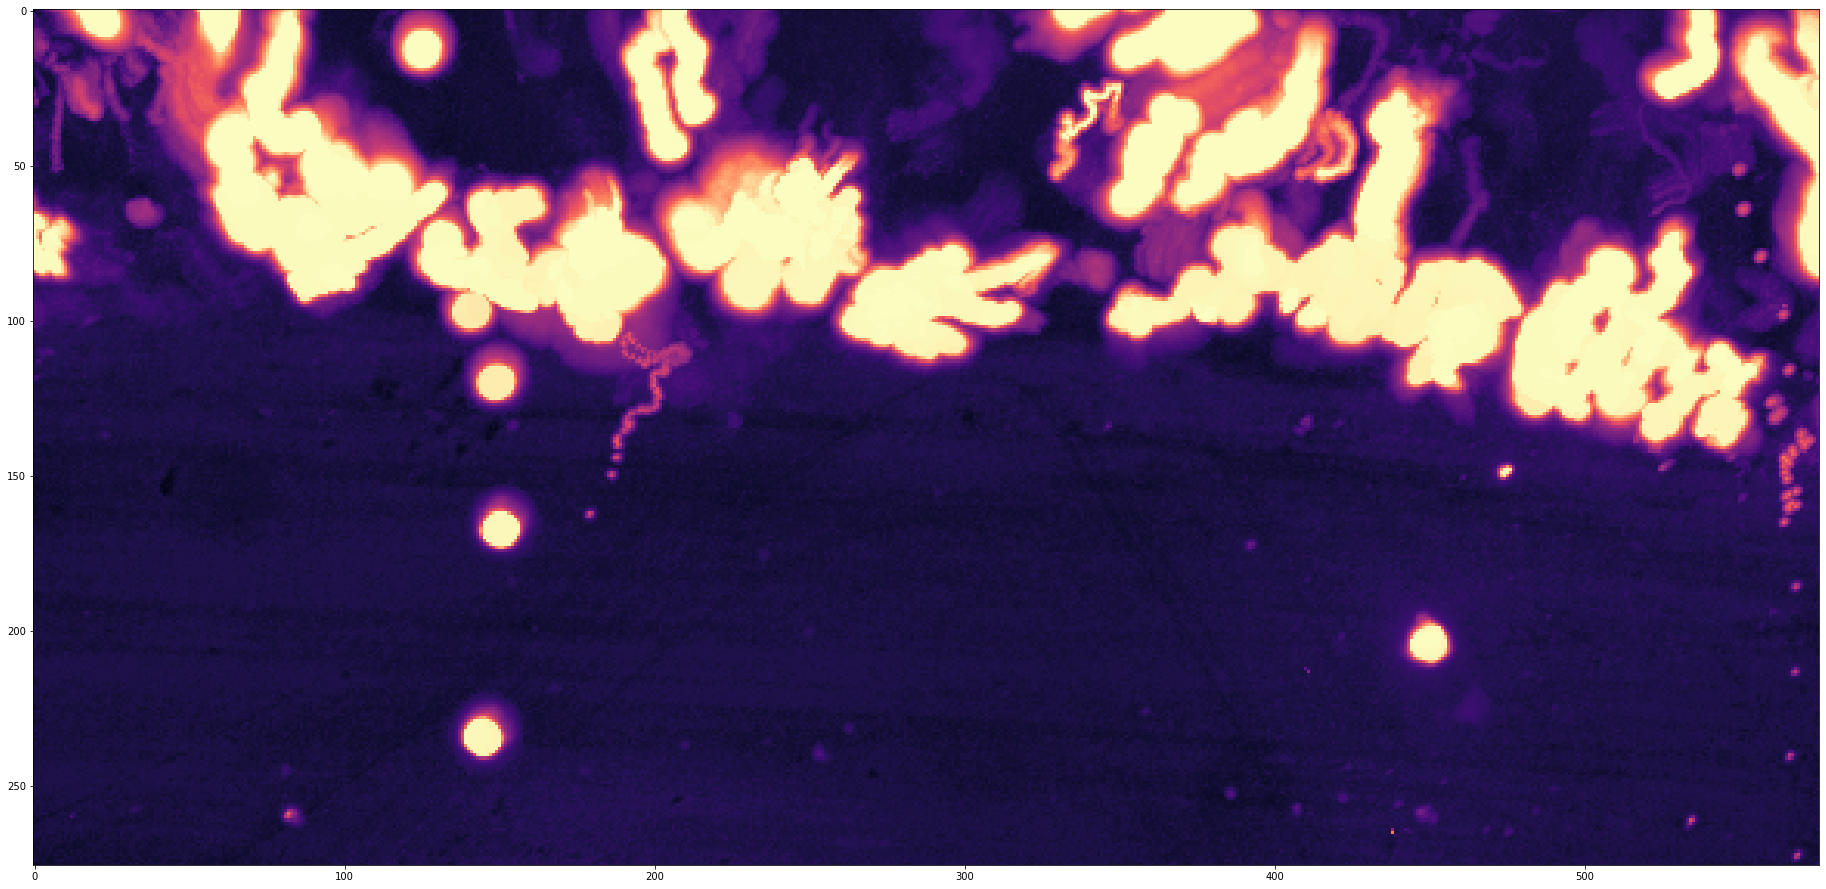

In [92]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [78]:
# Here we extract patches for training and validation.
patch_shape = (16, 16, 16)
patches = datagen.generate_patches_from_list(imgs[0:1], shape=patch_shape)

Generated patches: (124416, 16, 32, 32, 1)


In [93]:
X = patches[:int(len(patches)-(len(patches)/10)),:]
X_val = patches[int(len(patches)-(len(patches)/10)):,:]

print(np.shape(X_val))
print(np.shape(X))

(12442, 16, 32, 32, 1)
(111974, 16, 32, 32, 1)


In [ ]:
patch_shape = (32,32)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)
X = patches[:int(len(patches)-(len(patches)/5)),:]
X_val = patches[int(len(patches)-(len(patches)/5)):,:]

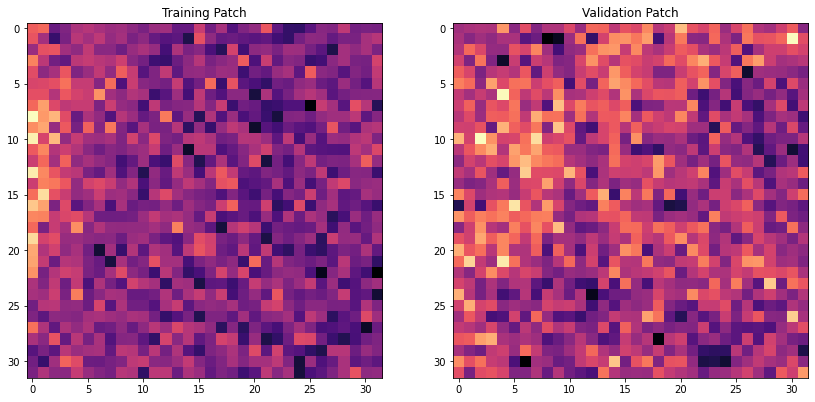

In [80]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,8,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,8,...,0],cmap='magma')
plt.title('Validation Patch');

In [81]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=30, n2v_perc_pix=0.198, n2v_patch_shape=(16, 16, 16), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['2494.7876'],
 'stds': ['6966.227'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 874,
 'train_learning_rate': 0.0004,
 'train_batch_size': 30,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (16, 16, 16),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'structN2Vmask': None,
 'probabilistic': False}

In [82]:
# a name used to identify the model
model_name = '2022_04_21_n2v_317cko'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)
# model.config.axes='YXC'
# # We load the data we want to process.
# input_train = imread('data/flower.tif')[...,None]

# # Here we process the data.
# # The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# # If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# # This can take longer.
# pred_train = []
# for _x in input_train[:2]:
#     _yp = model.predict(_x, axes='YXC', n_tiles=(1,1,1))
#     pred_train.append(_yp)
# pred_train = np.array(pred_train)

# # We load and process the data we previously used for validation.
# # input_val = imread('data/validation.tif')
# # pred_val = model.predict(input_val, axes='TYX')

C:\Users\17605\ImJoyApp\envs\n2v\lib\site-packages\n2v\models\n2v_standard.py:416: UserWarning: output path for model already exists, files may be overwritten: C:\Users\17605\Code\n2v\examples\3D\models\2022_04_21_n2v_317cko
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [83]:
history = model.train(X, X_val)


8 blind-spots will be generated per training patch of size (16, 16, 16).


Preparing validation data: 100%|███████████████████████████████████████████████| 12442/12442 [00:02<00:00, 5761.56it/s]


Epoch 1/200
874/874 [==============================] - 78s 86ms/step - loss: 0.8945 - n2v_mse: 0.8945 - n2v_abs: 0.2497 - val_loss: 0.1345 - val_n2v_mse: 0.1345 - val_n2v_abs: 0.1116
Epoch 2/200
874/874 [==============================] - 74s 85ms/step - loss: 0.2393 - n2v_mse: 0.2393 - n2v_abs: 0.1389 - val_loss: 0.1187 - val_n2v_mse: 0.1187 - val_n2v_abs: 0.0969
Epoch 3/200
874/874 [==============================] - 74s 85ms/step - loss: 0.2422 - n2v_mse: 0.2422 - n2v_abs: 0.1468 - val_loss: 0.0719 - val_n2v_mse: 0.0719 - val_n2v_abs: 0.0878
Epoch 4/200
874/874 [==============================] - 72s 83ms/step - loss: 0.1875 - n2v_mse: 0.1875 - n2v_abs: 0.1317 - val_loss: 0.3346 - val_n2v_mse: 0.3346 - val_n2v_abs: 0.2003
Epoch 5/200
874/874 [==============================] - 72s 82ms/step - loss: 0.2382 - n2v_mse: 0.2382 - n2v_abs: 0.1519 - val_loss: 0.9137 - val_n2v_mse: 0.9134 - val_n2v_abs: 0.2487
Epoch 6/200
874/874 [==============================] - 72s 82ms/step - loss: 0.1603 -

874/874 [==============================] - 70s 80ms/step - loss: 0.0143 - n2v_mse: 0.0143 - n2v_abs: 0.0450 - val_loss: 0.0317 - val_n2v_mse: 0.0317 - val_n2v_abs: 0.0703
Epoch 46/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0225 - n2v_mse: 0.0225 - n2v_abs: 0.0497 - val_loss: 0.0335 - val_n2v_mse: 0.0335 - val_n2v_abs: 0.0784
Epoch 47/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0121 - n2v_mse: 0.0121 - n2v_abs: 0.0429 - val_loss: 0.0305 - val_n2v_mse: 0.0305 - val_n2v_abs: 0.0691
Epoch 48/200
874/874 [==============================] - 72s 83ms/step - loss: 0.0152 - n2v_mse: 0.0152 - n2v_abs: 0.0440 - val_loss: 0.0324 - val_n2v_mse: 0.0324 - val_n2v_abs: 0.0666
Epoch 49/200
874/874 [==============================] - 76s 87ms/step - loss: 0.0152 - n2v_mse: 0.0152 - n2v_abs: 0.0458 - val_loss: 0.0320 - val_n2v_mse: 0.0320 - val_n2v_abs: 0.0619

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 50/200

874/874 [==============================] - 72s 83ms/step - loss: 0.0064 - n2v_mse: 0.0064 - n2v_abs: 0.0323 - val_loss: 0.0499 - val_n2v_mse: 0.0499 - val_n2v_abs: 0.0709
Epoch 88/200
874/874 [==============================] - 74s 85ms/step - loss: 0.0059 - n2v_mse: 0.0059 - n2v_abs: 0.0318 - val_loss: 0.0382 - val_n2v_mse: 0.0382 - val_n2v_abs: 0.0638
Epoch 89/200
874/874 [==============================] - 74s 84ms/step - loss: 0.0060 - n2v_mse: 0.0060 - n2v_abs: 0.0320 - val_loss: 0.0602 - val_n2v_mse: 0.0601 - val_n2v_abs: 0.0775

Epoch 00089: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 90/200
874/874 [==============================] - 76s 86ms/step - loss: 0.0047 - n2v_mse: 0.0047 - n2v_abs: 0.0307 - val_loss: 0.0451 - val_n2v_mse: 0.0451 - val_n2v_abs: 0.0668
Epoch 91/200
874/874 [==============================] - 76s 87ms/step - loss: 0.0056 - n2v_mse: 0.0056 - n2v_abs: 0.0324 - val_loss: 0.0459 - val_n2v_mse: 0.0459 - val_n2v_abs: 0.0686
Epoch 92/200


874/874 [==============================] - 73s 83ms/step - loss: 0.0045 - n2v_mse: 0.0045 - n2v_abs: 0.0298 - val_loss: 0.0433 - val_n2v_mse: 0.0433 - val_n2v_abs: 0.0661

Epoch 00129: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
Epoch 130/200
874/874 [==============================] - 73s 83ms/step - loss: 0.0050 - n2v_mse: 0.0050 - n2v_abs: 0.0295 - val_loss: 0.0439 - val_n2v_mse: 0.0439 - val_n2v_abs: 0.0655
Epoch 131/200
874/874 [==============================] - 72s 82ms/step - loss: 0.0074 - n2v_mse: 0.0074 - n2v_abs: 0.0330 - val_loss: 0.0422 - val_n2v_mse: 0.0422 - val_n2v_abs: 0.0644
Epoch 132/200
874/874 [==============================] - 72s 83ms/step - loss: 0.0048 - n2v_mse: 0.0048 - n2v_abs: 0.0296 - val_loss: 0.0642 - val_n2v_mse: 0.0642 - val_n2v_abs: 0.0787
Epoch 133/200
874/874 [==============================] - 73s 83ms/step - loss: 0.0053 - n2v_mse: 0.0053 - n2v_abs: 0.0316 - val_loss: 0.0534 - val_n2v_mse: 0.0534 - val_n2v_abs: 0.0710
Epoch 13

874/874 [==============================] - 70s 80ms/step - loss: 0.0062 - n2v_mse: 0.0062 - n2v_abs: 0.0312 - val_loss: 0.0479 - val_n2v_mse: 0.0479 - val_n2v_abs: 0.0690
Epoch 172/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0060 - n2v_mse: 0.0060 - n2v_abs: 0.0310 - val_loss: 0.0462 - val_n2v_mse: 0.0462 - val_n2v_abs: 0.0677
Epoch 173/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0064 - n2v_mse: 0.0064 - n2v_abs: 0.0323 - val_loss: 0.0672 - val_n2v_mse: 0.0672 - val_n2v_abs: 0.0819
Epoch 174/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0054 - n2v_mse: 0.0054 - n2v_abs: 0.0300 - val_loss: 0.0478 - val_n2v_mse: 0.0478 - val_n2v_abs: 0.0697
Epoch 175/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0070 - n2v_mse: 0.0070 - n2v_abs: 0.0317 - val_loss: 0.0453 - val_n2v_mse: 0.0453 - val_n2v_abs: 0.0656
Epoch 176/200
874/874 [==============================] - 70s 80ms/step - loss: 0.0052 - n

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


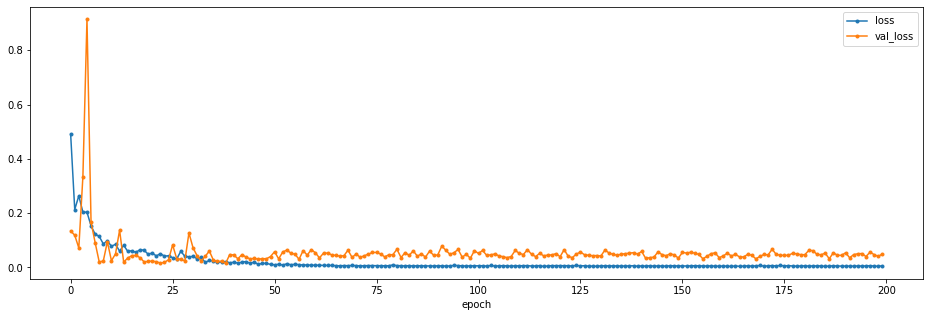

In [84]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [85]:
model.export_TF(name='Noise2Void: PIV denoising', 
                description='N2V trained in python on exp 317 dataset PIV.', 
                authors=["Jesse Holt"],
                test_img=X_val[0,...,0], axes='ZYX',
                patch_shape=patch_shape)

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\17605\AppData\Local\Temp\tmp9m9jfcun\model\saved_model.pb

Model exported in BioImage ModelZoo format:
C:\Users\17605\Code\n2v\examples\3D\models\2022_04_21_n2v_317cko\export.bioimage.io.zip


In [87]:
# Previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model = N2V(config=None, name=model_name, basedir=basedir)


Loading network weights from 'weights_best.h5'.


In [88]:
# We load the data we want to process.
img = imread( "F:/Jesse/cKO/317_2021_03_27_mkera_batch66_ScratchFast/n2v/C1-317_2021_03_27_mkera_batch66_ScratchFast_1_MMStack_Pos0-Skin4.ome.tif")

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:42<00:00,  1.33s/it]


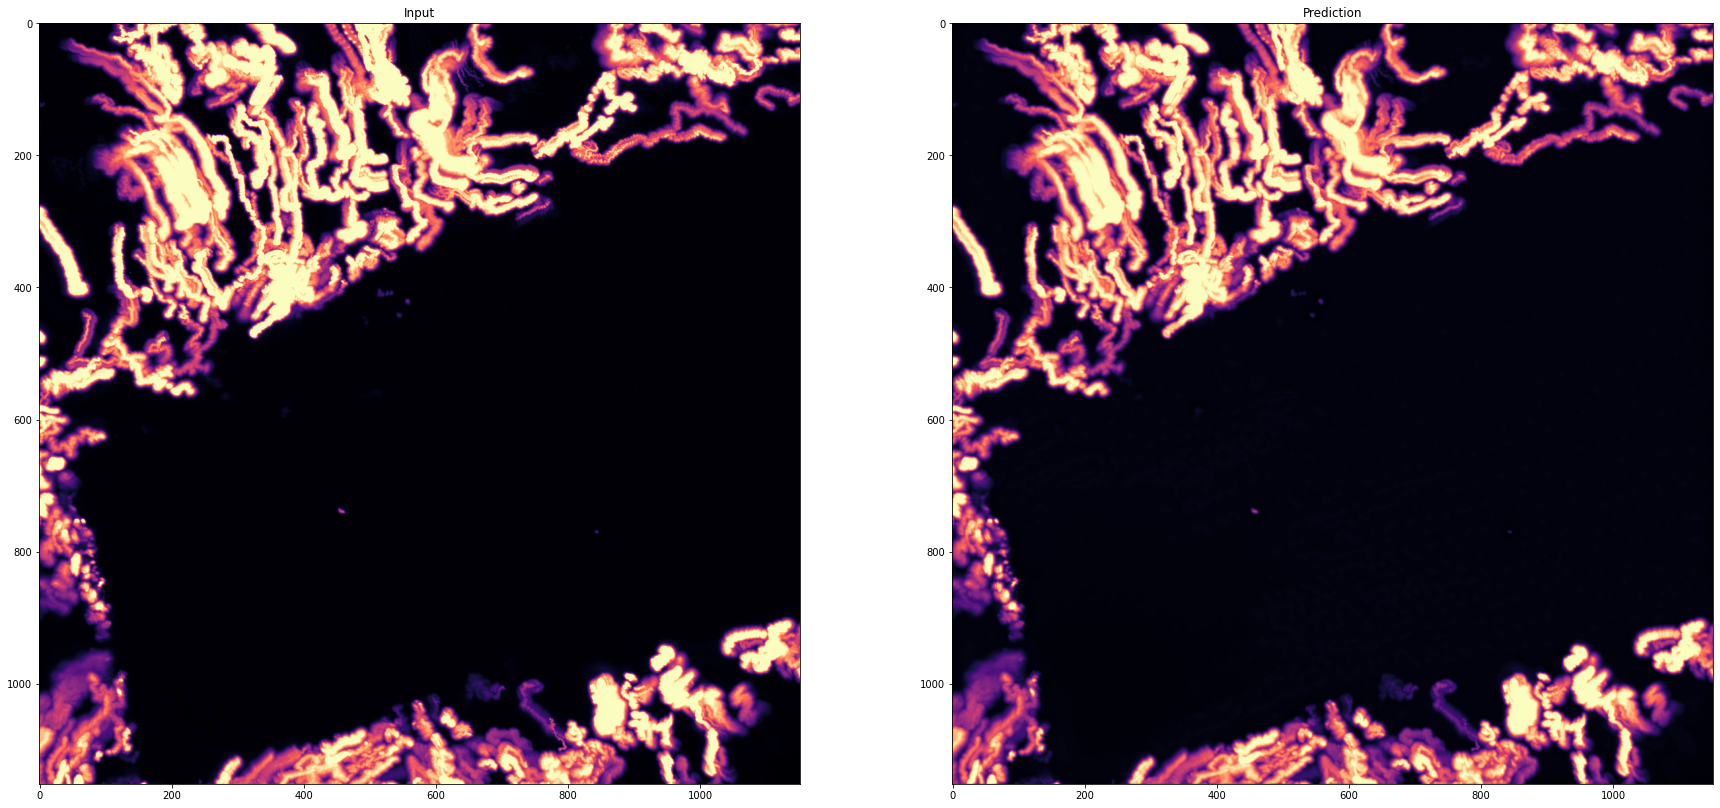

In [89]:

# Let's look at the results.
plt.figure(figsize=(30,30))

# We show the noisy input...
plt.subplot(1,2,1)
plt.imshow(np.max(img,axis=0),
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Input');

# and the result.
plt.subplot(1,2,2)
plt.imshow(np.max(pred,axis=0), 
           cmap='magma',
           vmin=np.percentile(pred,0.1),
           vmax=np.percentile(pred,99.9)
          )
plt.title('Prediction');

In [90]:
save_tiff_imagej_compatible('prediction_noclahe.tif', pred, 'ZYX')

In [ ]:
from datetime import datetime

ErrorFiles=[]
datagen = N2V_DataGenerator()
folder = "F:/Jesse/cKO/cKO_PIV_less/Nuclei/317/"
imgs = datagen.load_imgs_from_directory(directory = folder, filter = '*.tif', dims='ZYX')
patch_shape = (16, 16, 16)
date = datetime.now().strftime("%Y_%m_%d_")
img_list =  sorted(glob.glob(os.path.join(folder, "*.tif")))

for i in range(len(imgs)):
    try:
        # Here we extract patches for training and validation.
        patches = datagen.generate_patches_from_list(imgs[i:i+1], shape=patch_shape)
        X = patches[:int(len(patches)-(len(patches)/10)),:]
        X_val = patches[int(len(patches)-(len(patches)/10)):,:]
        
        
        sfx = img_list[i].split('\\')
        file_name = sfx[-1][:-4] 
        
        config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=30, n2v_perc_pix=0.198, n2v_patch_shape = patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

        # a name used to identify the model
        model_name = f'{date}{file_name}'
        # the base directory in which our model will live
        basedir = 'models'
        # We are now creating our network model.
        model = N2V(config=config, name=model_name, basedir=basedir)
        
        history = model.train(X, X_val)
        
        model.export_TF(name=f'Noise2Void: PIV denoising of {file_name}', 
                description='N2V trained in python on exp 317 dataset PIV.', 
                authors=["Jesse Holt"],
                test_img=X_val[0,...,0], axes='ZYX',
                patch_shape=patch_shape)

        print(sorted(list(history.history.keys())))
        plt.figure(figsize=(16,5))
        plot_history(history,['loss','val_loss']);
        
        model = N2V(config=None, name=model_name, basedir=basedir)
        
        img = imread(img_list[i])
        
        pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))
        
        save_tiff_imagej_compatible(f'{file_name}_prediction.tif', pred, 'ZYX')

    except:
        sfx = img_list[i].split('\\')
        file_name = sfx[-1][:-4] 
        ErrorFiles.append(file_name)
        pass

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

Generated patches: (58752, 16, 16, 16, 1)
8 blind-spots will be generated per training patch of size (16, 16, 16).


Preparing validation data: 100%|████████████████████████████████████████████████| 5876/5876 [00:00<00:00, 12347.05it/s]


Epoch 1/200
413/413 [==============================] - 31s 69ms/step - loss: 0.2929 - n2v_mse: 0.2929 - n2v_abs: 0.2569 - val_loss: 0.2281 - val_n2v_mse: 0.2277 - val_n2v_abs: 0.2162
Epoch 2/200
413/413 [==============================] - 27s 66ms/step - loss: 0.1674 - n2v_mse: 0.1674 - n2v_abs: 0.2069 - val_loss: 0.1210 - val_n2v_mse: 0.1208 - val_n2v_abs: 0.1767
Epoch 3/200
413/413 [==============================] - 28s 67ms/step - loss: 0.1461 - n2v_mse: 0.1461 - n2v_abs: 0.1984 - val_loss: 0.1507 - val_n2v_mse: 0.1506 - val_n2v_abs: 0.2659
Epoch 4/200
413/413 [==============================] - 27s 67ms/step - loss: 0.2272 - n2v_mse: 0.2272 - n2v_abs: 0.2267 - val_loss: 0.2355 - val_n2v_mse: 0.2351 - val_n2v_abs: 0.2128
Epoch 5/200
 97/413 [======>.......................] - ETA: 18s - loss: 0.1092 - n2v_mse: 0.1092 - n2v_abs: 0.1880

In [ ]:
ErrorFiles